# Exploring deep sea acoustic events
## Whale song detector: EDA for whale example clips

### Feb 2020 PDSG Applied Data Science Meetup series<br>John Burt

### Session details

For February’s four session meetup series we’ll be working with long term hydrophone recordings from University of Hawaii's Aloha Cabled Observatory (ACO - http://aco-ssds.soest.hawaii.edu), located at a depth of 4728m off Oahu. The recordings span a year and contain many acoustic events: wave movements, the sound of rain, ship noise, possible bomb noises, geologic activity and whale calls and songs. There is a wide range of project topics to explore: identifying and counting acoustic events such as whale calls, measuring daily or seasonal noise trends, measuring wave hydrodynamics, etc.

### This notebook:

For the whale song detector, I needed to prepare a set of clean song examples to train my classifier with. For this I clipped several hundred examples of humpback whale song from WHOI Watson library recordings that I downloaded. The clips are of individual song notes and range from ~ 1 sec to 8 sec long. I want to know some details about these vocalizations:

- What is the frequency range?
- What do the song notes look like?
- Are there specific classes of note types that can be separated by frequency, or are they a continuous range?


Packages required:
- librosa


In [15]:
from IPython.display import HTML
# from IPython.display import Image
# Image("eyeexam.jpg")

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [16]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

import pandas as pd
pd.options.display.max_columns = 100

import numpy as np

import librosa
import librosa.display


## Humpback whale song

>A humpback song can be broken down into a number of “themes”. In turn, each theme contains a number of repetitions of a phrase. Phrases may last for 20-40 seconds, while entire songs may be longer than 30 minutes. Themes are generally sung in a particular order and the singing whale can take about 10 minutes to come back to the original theme. The structure of the song is complex and hierarchical, consisting of short and long segments with multiple layers of repetition or periodicities that may contain six units or even 400 units. The song conveys one bit of information per second, compared to humans with approximately ten bits per second.

>From: [Parsons et al "The Nature of Humpback Whale (Megaptera novaeangliae) Song" Journal of Marine Animals and Their Ecology (2008)](http://oers.ca/journal/journal1/Volume1/Issue1_6parsons2008.pdf)

### This is a partial song recorded off Maui in 2004: 

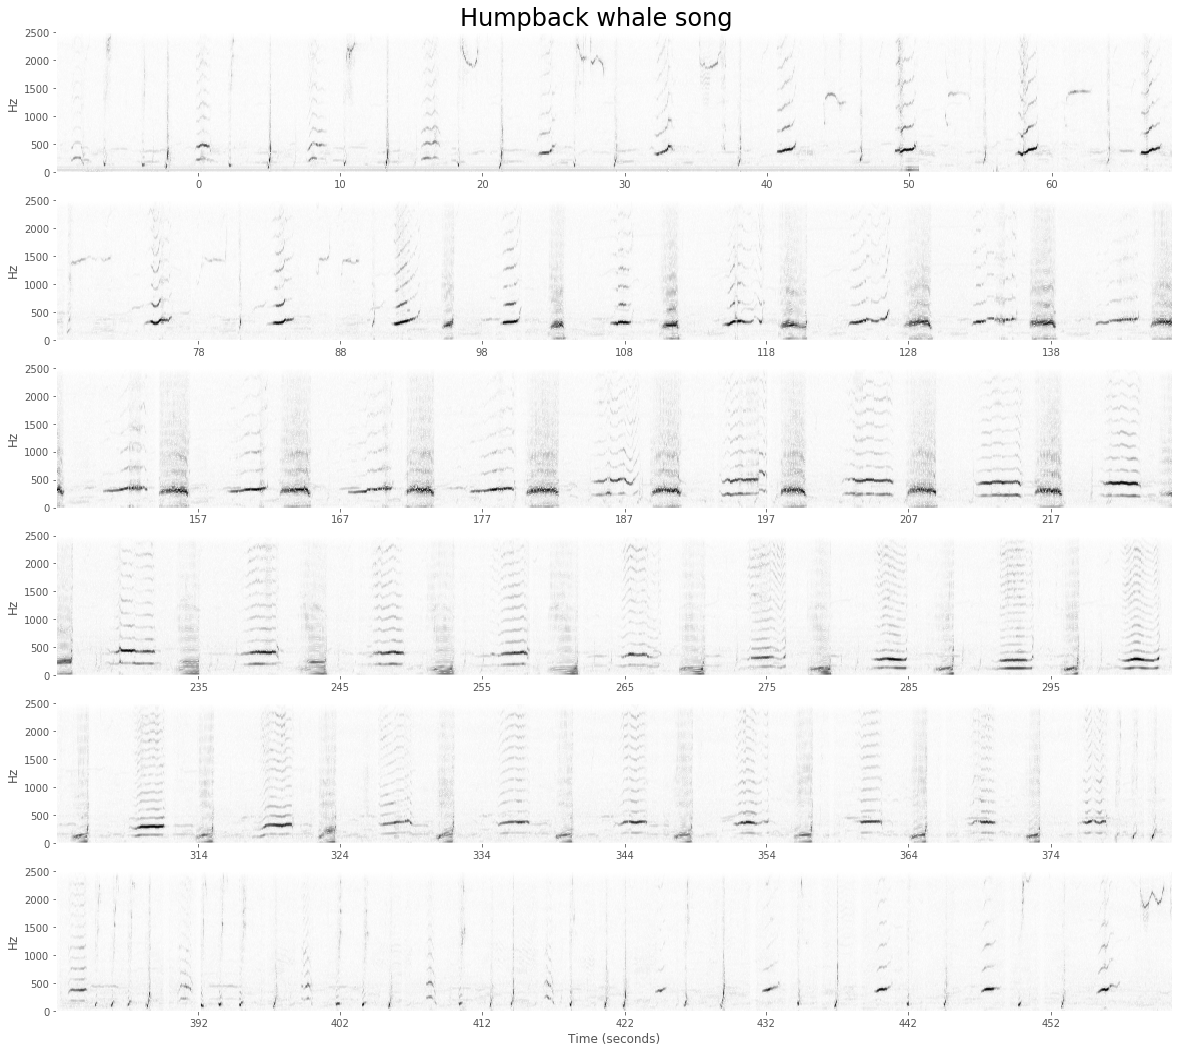

In [17]:
# whale song recorded off Maui
songfile = './whale_trust/HIJ1704_maui_2004,song,00 25 22,part,00 00 00.wav'

samprate = 5000
fftsize = 256
hoplength = fftsize

# load a whale song as waveform, resample to samprate
y, sr = librosa.load(songfile, sr=samprate)

# calculate spectrograph of the recording
spec = np.abs(librosa.stft(y, hop_length=hoplength, n_fft=fftsize))

numrows = 6
figheight = 3
fftperiod = fftsize/samprate
tickpos = (np.arange(10,int(spec.shape[1]*fftperiod/numrows), 10)/fftperiod).astype(int)

plt.figure(figsize=(20,numrows*figheight))

for i in range(numrows):
    plt.subplot(numrows,1,i+1)
    fstart = int(i*(spec.shape[1]/numrows))
    fend = int((i+1)*(spec.shape[1]/numrows))
    librosa.display.specshow(np.power(spec[:,fstart:fend],0.4),sr=samprate, y_axis='linear',cmap='Greys')
    timeticks = ['%d'%(t) for t in np.arange(fstart*fftperiod,fend*fftperiod, 10)]
    plt.xticks(tickpos, timeticks)
    
plt.xlabel('Time (seconds)')
plt.suptitle('Humpback whale song', y=.9, fontsize=24);


## Prepare the sound data and generate spectrographs

- Read target sound paths from clip folder
- Read the target sounds clips, converting them to 5kHz sample rate
- Generate spectrographs for every clip

### Notes:

- Target sounds are individual wave file clips stored in a single folder.


- A spectrograph is a time x frequency x amplitude representation of a sound. It can be treated as a 2D array (image) for analysis purposes.



In [18]:
#Read target sound paths from clip folder

import os
import fnmatch
from datetime import datetime,timedelta  

# dir containing sound clips to sample containing target sounds to detect
srcdir = './data/model/source/target/'

# these will all be wav files
clipexts=['*.wav']

# search through source folder for sound files
# save clip path and date (parsed from filename)
clippath = []
for ext in clipexts:
    for root, dirnames, filenames in os.walk(srcdir):
        for filename in fnmatch.filter(filenames, ext):
            clippath.append(os.path.join(root, filename).replace('\\','/'))
                

In [19]:
# Read the target sounds clips, converting them to 5kHz sample rate

# Librosa helpfully combines the file load and resample operations.
samprate = 5000

y = []
for path in clippath:
    y.append(librosa.load(path, sr=samprate)[0])

print('Number of whale song note clips loaded:',len(y))

Number of whale song note clips loaded: 564


In [20]:
hoplength=None
fftsize=128

spec = []
for clip in y:
    # append spectrograph
    spec.append(np.abs(librosa.stft(clip, hop_length=hoplength, n_fft=fftsize)))


## Examples of target sound spectrographs

Looking at these whale song notes, I can see that there is a lot of variability in frequency, duration and harmonic content.

Note: I prefer to use a black-on-white grayscale image. This format shows audio features best and is best for printing.

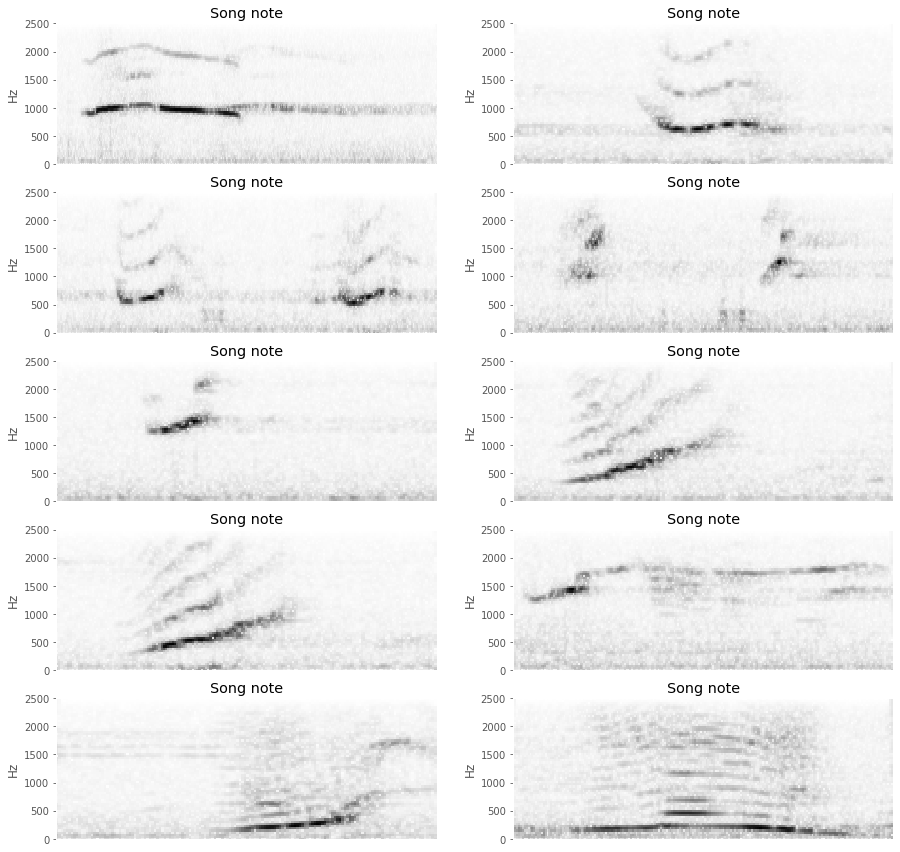

In [21]:
figsize = (15,15)
plt.figure(figsize=figsize)
plt.subplot(5,2,1)
nspecs = 10
for i, s in zip(range(nspecs), spec[:nspecs]):
    plt.subplot(5,2,i+1)
    librosa.display.specshow(np.power(s,0.4),sr=samprate, y_axis='linear',cmap='Greys')
    plt.title('Song note')
    

## Look at overall max spectral amplitude

I want to know where the whales are putting most of their vocal energy. Here, I combine max spectral amplitudes for all target sounds (sound waveforms were previously set to the same range of levels).

Looking at the figure, it appears there are roughly two peaks: very low frequency (about 20-60 Hz) and mid (about 100-350 Hz). Then there are sounds produced in a higher frequency region above 500 Hz. Those sounds are lower amplitude and amplitude drops off as frequency increases.

In [22]:
def get_mean_spectrum(spec, sr, frange=[0,-1]):
    """Mean magnitude of each spectrograph frequency bin"""
    nbins = spec.shape[0]
    minbin = int(np.round(frange[0]*nbins*2/sr))
    if frange[1] > 0:
        maxbin = min(nbins,int(np.round(frange[1]*nbins*2/sr)))
    else:
        maxbin = nbins
    return np.mean(spec[minbin:maxbin,:],axis=1)

def get_max_spectrum(spec, sr, frange=[0,-1]):
    """Max magnitude of each spectrograph frequency bin"""
    nbins = spec.shape[0]
    minbin = int(np.round(frange[0]*nbins*2/sr))
    if frange[1] > 0:
        maxbin = min(nbins,int(np.round(frange[1]*nbins*2/sr)))
    else:
        maxbin = nbins
    return np.max(spec[minbin:maxbin,:],axis=1)

def whiten_spec(spec, pctile=95):
    """Threshold a spectrograph based on a given percentile magnitude"""
    specw = spec.copy()
    for row in range(spec.shape[0]):
        specw[row,specw[row,:]<np.percentile(specw[row,:],pctile)] = 0
    return specw

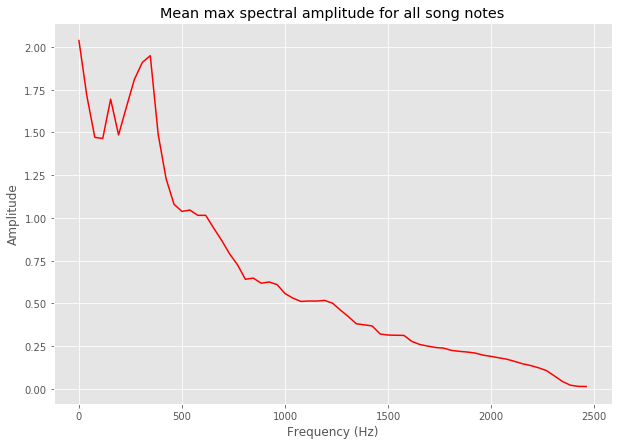

In [23]:
pctile = 90

specmean = np.zeros([spec[0].shape[0],])

for s in spec:
    specmean += get_max_spectrum(s, samprate)
    
specmean /= len(spec)
# specmeanw /= len(spec)

freqs = np.arange(len(specmean)) * samprate/(len(specmean)*2)

plt.figure(figsize=(10,7))
plt.plot(freqs, specmean, 'r-')
plt.ylabel('Amplitude')
plt.xlabel('Frequency (Hz)')
plt.title('Mean max spectral amplitude for all song notes');


## Looking at individual target sound spectra

Using the mean of the maximum magnitude for each frequency bin of the spectrograph is useful for examining the spectrum of the loudest parts of a signal. A mean measure of spectral content loses the time-varying information in a sound, but it provides a simple description of a signal.

In this case, the song notes are mostly made up of a dominant frequency, with harmonics and partial tones. This is typical for vocal organs that produce pulsatile, or non-sinusoidal acoustic output. Also, some of the harmonic content could be caused by distortion artifacts in the recordings introduced by the hydrophone or tape recorder/player.

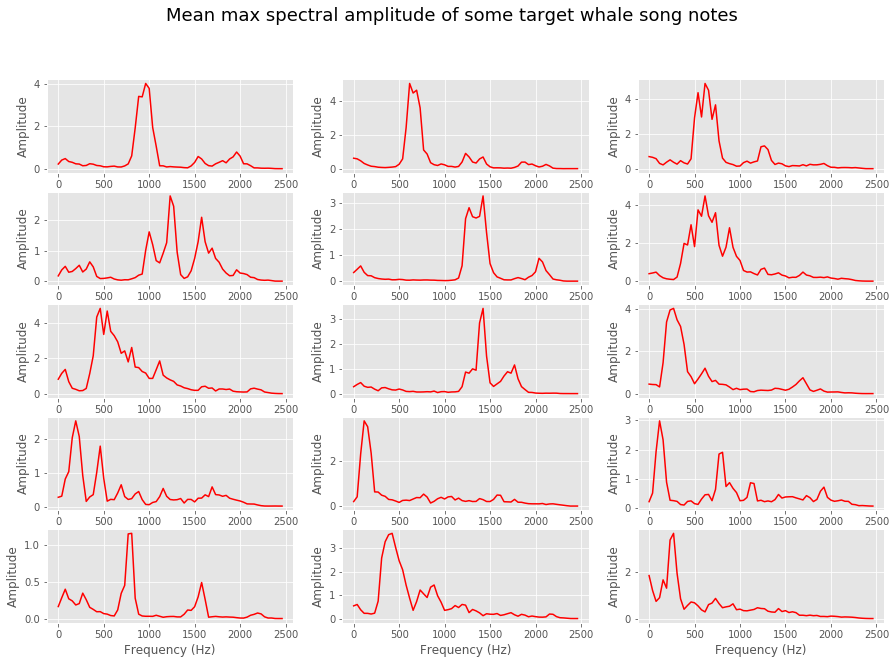

In [24]:
frange = [150,2000]
pctile = 80
nrows = 5
ncols = 3
nfigs = nrows * ncols

plt.figure(figsize=(15,10))
for i, s in zip(range(nfigs),spec[:nfigs]):
    sms = get_max_spectrum(s, samprate)
    freqs = np.arange(len(sms)) * samprate/(len(sms)*2)
    plt.subplot(nrows,ncols,i+1)
    plt.plot(freqs, sms, 'r-',label='original')
    plt.ylabel('Amplitude')
    plt.xlabel('Frequency (Hz)')
plt.suptitle('Mean max spectral amplitude of some target whale song notes', fontsize=18);


## Pairwise correlations

I generate a similarity matrix by applying a pairwise Pearson correlation to the mean max spectra of all target sounds. The similarity matrix is quite contrasty, indicating a good range of very similar and very dissimilar (even negative correlation) pairings.

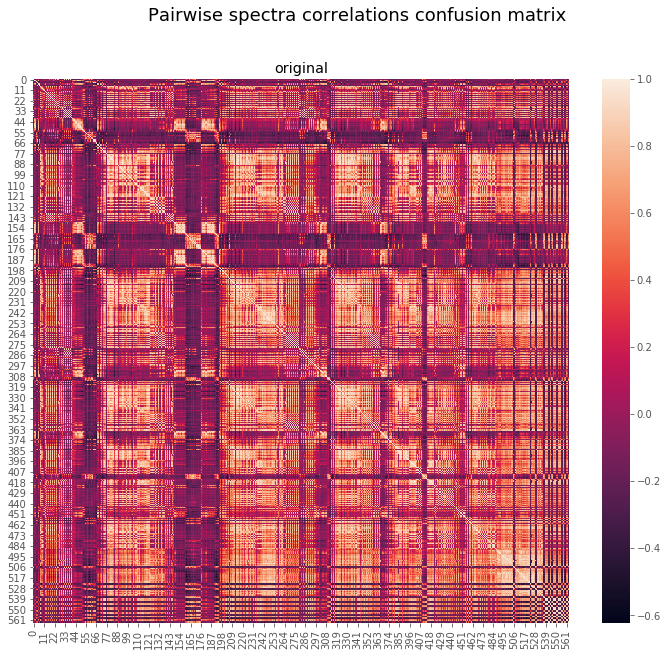

In [25]:
import seaborn as sn

frange = [150,2000] # freq range to cut from spec

plt.figure(figsize=(12,10))

plt.suptitle('Pairwise spectra correlations confusion matrix', fontsize=18)

sms = []
for s in spec:
    sms.append(get_max_spectrum(s, samprate, frange=frange))
    
cor = np.corrcoef(sms)
sn.heatmap(cor);
plt.title('original');


## Reduce to 3 dimensions and plot similarity mapping

I use PCA to reduce the columns of the similarity matrix to 3 coordinates per target sound. Plotting the similarity mapping reveals what appear to be roughly three clusterings of sounds. 

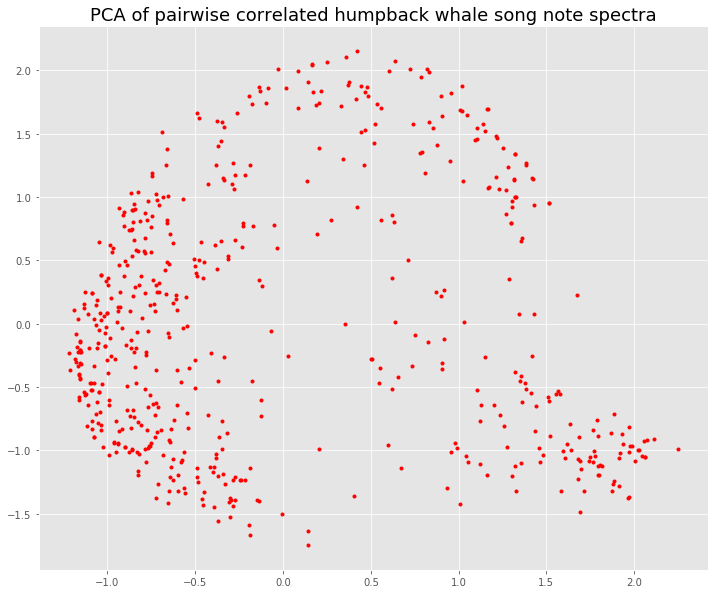

In [26]:
from sklearn.decomposition import PCA

ndims = 3

plt.figure(figsize=(12,10))

plt.title('PCA of pairwise correlated humpback whale song note spectra', fontsize=18);

coords = PCA(n_components=ndims, whiten=True).fit_transform(cor)
plt.plot(coords[:,0], coords[:,1], 'r.');
          

## Cluster using KMeans

Assigning three clusters using KMeans works fairly well: especially if you look at the third dimension, it appears the whales produce three distinct sound types for their songs.

Note: I tried several other clustering methods, and none were particularly better than KMeans. 

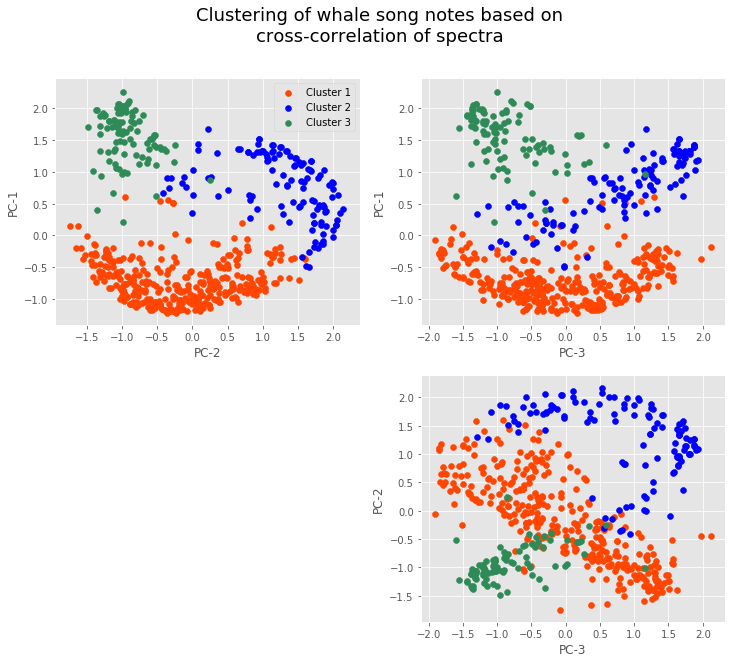

In [27]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering

n_clusters = 3

coords_used = coords
clmodel = KMeans(n_clusters=n_clusters, random_state=10)
cl = clmodel.fit_predict(coords_used)
# cl = SpectralClustering(n_clusters=n_clusters, random_state=10).fit_predict(coords_used)
# cl = AgglomerativeClustering(n_clusters=n_clusters).fit_predict(coords_used)

# cl = DBSCAN().fit_predict(coords_used)
# cl = AffinityPropagation().fit_predict(coords_used)
# n_clusters = np.unique(cl).shape[0]

plt.figure(figsize=(12,10))
plt.suptitle('Clustering of whale song notes based on\ncross-correlation of spectra', fontsize=18)
plt.subplot(2,2,1)
cdict = {0: 'orangered', 1: 'blue', 2: 'seagreen'}
for clnum in range(n_clusters):
    cl_coord = coords_used[cl==clnum,:]
    plt.scatter(cl_coord[:,1], cl_coord[:,0], c=cdict[clnum], label='Cluster '+str(clnum+1))
plt.xlabel('PC-2')
plt.ylabel('PC-1');
plt.legend();

plt.subplot(2,2,2)
for clnum in range(n_clusters):
    cl_coord = coords_used[cl==clnum,:]
    plt.scatter(cl_coord[:,2], cl_coord[:,0], c=cdict[clnum], label='Cluster '+str(clnum+1))
plt.xlabel('PC-3')
plt.ylabel('PC-1');

plt.subplot(2,2,4)
for clnum in range(n_clusters):
    cl_coord = coords_used[cl==clnum,:]
    plt.scatter(cl_coord[:,2], cl_coord[:,1], c=cdict[clnum], label='Cluster '+str(clnum+1))
plt.xlabel('PC-3')
plt.ylabel('PC-2');



## Spectrographs of target sounds nearest to each cluster centroid

For this analysis, I wanted to visualize the most typical sounds in each of the three clusters. So I selected the six sounds closest to each cluster centroid and plotted their spectrograph.

My impression here is that each sound type is grouped mostly by note frequency, but there are other differences: 

- **Cluster 1** - Low notes (~50-250 Hz): These sound like growls or groans, and often have a lot of harmonic content. They are much like human speech, which due to being pulsatile in nature produces a lot of harmonic energy. Humans modulate the fundamental pulse frequency but also use their oral/nasal cavity shape to selectively filter the larynx output into complex sounds. The whales may be doing something similar, although how they do that is unknown as far as I'm aware. 


- **Cluster 2** - Mid-range notes (~500 Hz): These sounds show up as variable whistles and groans.


- **Cluster 3** - Higher frequency notes (~1000-2000 Hz): A highly variable category, but seemingly distinct in being much higher frequency and briefer often with rapid repetition of the same note, or a long whistle-like note.


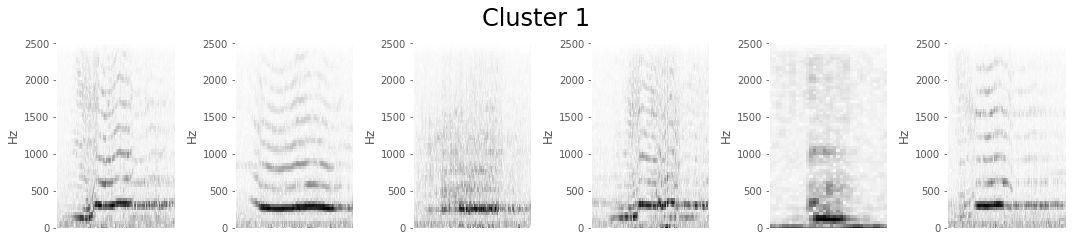

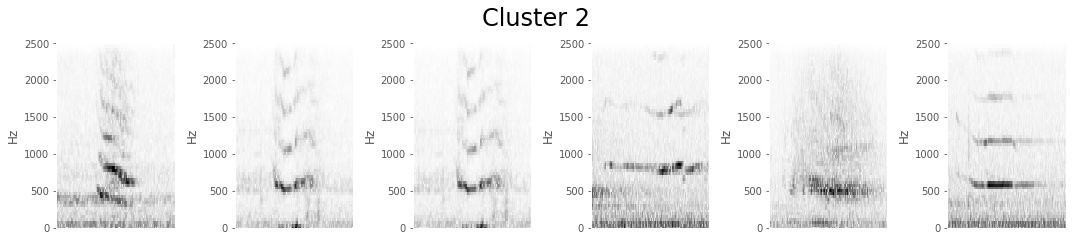

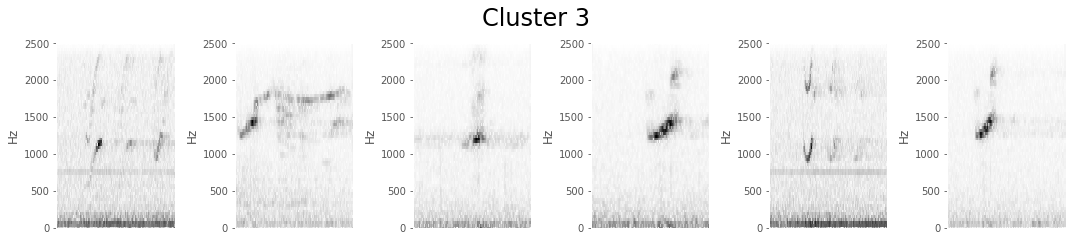

In [28]:
from scipy.spatial import distance

nexamp = 6


for clnum, clid in zip(range(n_clusters),np.unique(cl)):
    clidx = np.arange(len(cl))[cl==clid]
    clcoords = coords_used[clidx,:]
    centdist = [distance.euclidean(coord,clmodel.cluster_centers_[clnum,:]) for coord in clcoords]
    sortidx = clidx[np.argsort(centdist)]
  
    plt.figure(figsize=(15,3))
    for i,idx in zip(range(nexamp),sortidx[:nexamp]):
        plt.subplot(1, nexamp, i+1)
        librosa.display.specshow(np.power(spec[idx],0.4), sr=samprate, y_axis='linear',cmap='Greys')
        plt.suptitle('Cluster '+str(clid+1),fontsize = 24, y=1.1);
        plt.tight_layout();
    